# Toronto Housing Price Prediction Model

## Introduction
This notebook details our efforts to develop a reliable housing price prediction model for the Toronto area. Given the absence of a robust model for this region, we utilized the Zillow API to gather data for training.

## Data Collection
Training data was acquired using the Zillow API (see `get-data/zillow.py` script). The dataset includes various features of homes recently sold, or available for sale in GTA area.

## Preprocessing
The dataset underwent significant preprocessing:
- Removal of columns with excessive missing values or low predictive power.
- Encoding of categorical variables such as `homeType` to numerical format suitable for modeling.
- Removal of duplicate entries and entries with zero price.

## Model Development
Two models were developed and evaluated:
1. **Linear Regression**
2. **Random Forest**

# Loading the Dataset

In [593]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats
from scipy.stats import norm, skew 

def load_dataset(filename):
    df = pd.read_csv(filename)
    return df
df = load_dataset("zillow_homes_sold_toronto.csv")



In [594]:
df['homeStatusForHDP'].value_counts()

homeStatusForHDP
RECENTLY_SOLD    5042
FOR_RENT           98
FOR_SALE           80
Name: count, dtype: int64

In [595]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5220 entries, 0 to 5219
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   isShowcaseListing        5220 non-null   bool   
 1   longitude                412 non-null    float64
 2   timeOnZillow             5100 non-null   float64
 3   zestimate                54 non-null     float64
 4   daysOnZillow             5220 non-null   int64  
 5   zpid                     5220 non-null   int64  
 6   taxAssessedValue         54 non-null     float64
 7   isUnmappable             5220 non-null   bool   
 8   priceForHDP              5220 non-null   int64  
 9   dateSold                 5220 non-null   int64  
 10  state                    5220 non-null   object 
 11  isFeatured               5220 non-null   bool   
 12  isPremierBuilder         5220 non-null   bool   
 13  isPreforeclosureAuction  5220 non-null   bool   
 14  lotAreaValue            

In [596]:
print(df.isnull().sum())

isShowcaseListing             0
longitude                  4808
timeOnZillow                120
zestimate                  5166
daysOnZillow                  0
zpid                          0
taxAssessedValue           5166
isUnmappable                  0
priceForHDP                   0
dateSold                      0
state                         0
isFeatured                    0
isPremierBuilder              0
isPreforeclosureAuction       0
lotAreaValue               3230
isNonOwnerOccupied            0
homeStatus                    0
latitude                   4808
lotAreaUnit                3230
bedrooms                      0
zipcode                       0
homeStatusForHDP              0
isZillowOwned                 0
shouldHighlight               0
homeType                      0
bathrooms                     0
rentZestimate              5165
price                         0
city                          0
streetAddress                 0
country                       0
currency

# Data Preprocessing and Clean up

## Removing columns
Columns like state, homeStatus, lotAreaUnit, homeType, city, streetAddress, country, and currency are categorical and should be encoded to numerical values if you plan to use them in your model.


In [597]:
def drop_columns(df):
    columns_with_many_missing = df.columns[df.isnull().mean() > .99]
    columns_with_low_predictive_power = [
        'zpid', 'streetAddress', 'listing_sub_type', 
        'isUnmappable', 'isShowcaseListing', 'isFeatured', 
        'isPremierBuilder', 'isPreforeclosureAuction', 
        'isNonOwnerOccupied', 'isZillowOwned', 'shouldHighlight',
        'city', 'streetAddress', 'country', 'currency', 'zpid', 'lotAreaUnit',
        'homeStatusForHDP', 'homeStatus', 'state',
        'zestimate', 'taxAssessedValue', 'rentZestimate',
        'zipcode',
        'dateSold',
        'priceForHDP',
        # 'daysOnZillow'
    ]

    columns_to_drop = list(set(columns_with_many_missing.to_list() + columns_with_low_predictive_power))

    df_dropped = df.drop(columns=columns_to_drop)

    print(f"Number of rows: {df.shape[0]}")
    print("columns_with_many_missing:", columns_with_many_missing)
    print("Columns dropped:", columns_to_drop)
    print("\nRemaining columns:", df_dropped.columns.tolist())

    df_dropped.head()
    return df_dropped

df = drop_columns(df)

Number of rows: 5220
columns_with_many_missing: Index([], dtype='object')
Columns dropped: ['currency', 'lotAreaUnit', 'isPreforeclosureAuction', 'zpid', 'priceForHDP', 'country', 'dateSold', 'isFeatured', 'isPremierBuilder', 'listing_sub_type', 'isShowcaseListing', 'shouldHighlight', 'isNonOwnerOccupied', 'streetAddress', 'homeStatusForHDP', 'homeStatus', 'taxAssessedValue', 'isUnmappable', 'zipcode', 'rentZestimate', 'isZillowOwned', 'city', 'state', 'zestimate']

Remaining columns: ['longitude', 'timeOnZillow', 'daysOnZillow', 'lotAreaValue', 'latitude', 'bedrooms', 'homeType', 'bathrooms', 'price', 'livingArea']


## Categorical Data Encoding
Since homeType is a categorical variable, we'll need to encode it to use it in most machine learning models, which require numerical input.

One-Hot Encoding: This method converts the categorical variable into a series of binary columns, each representing a unique category. One-hot encoding is suitable when there is no ordinal relationship between the categories. Since homeType likely does not have a natural order, this method is appropriate.

In [598]:
df['homeType'].value_counts()

homeType
SINGLE_FAMILY    3577
CONDO             905
APARTMENT         461
TOWNHOUSE         222
MULTI_FAMILY       55
Name: count, dtype: int64

## Using One-hot encoding on HomeType
Many machine learning algorithms including Linear Regression and Random Forest are designed to work primarily with numerical data, making it challenging to directly incorporate categorical data (such as text labels) into models. One-hot encoding transforms these categorical labels into a numeric format by creating new binary columns for each category. For example, if the original data column has categories like Condo, Townhouse, and Single Family, one-hot encoding converts this into three separate binary columns (e.g., Condo, Townhouse, Single Family), where each property is marked with a 1 under the column of its category and 0s under all others. This numerical transformation allows algorithms to perform operations like calculation of splits in decision trees or coefficients in regression models, which wouldn't be directly possible with non-numeric data.

In [599]:
print(df.columns)
print(df.shape[0])
df.head()



Index(['longitude', 'timeOnZillow', 'daysOnZillow', 'lotAreaValue', 'latitude',
       'bedrooms', 'homeType', 'bathrooms', 'price', 'livingArea'],
      dtype='object')
5220


,longitude,timeOnZillow,daysOnZillow,lotAreaValue,latitude,bedrooms,homeType,bathrooms,price,livingArea
0,NaN,6.205267e+10,718,NaN,NaN,0,CONDO,1.0,430000,NaN
1,-79.419914,8.036947e+10,930,NaN,43.661144,0,SINGLE_FAMILY,1.0,1452000,750.0
2,NaN,8.131987e+10,941,NaN,NaN,0,CONDO,1.0,430000,NaN
3,NaN,8.563987e+10,991,NaN,NaN,0,SINGLE_FAMILY,4.0,1300000,NaN
4,NaN,6.205267e+10,718,NaN,NaN,0,CONDO,1.0,430000,NaN


In [600]:
def encode_homeType(df):
    from sklearn.preprocessing import OneHotEncoder

    encoder = OneHotEncoder(drop='first')

    homeType_encoded_sparse = encoder.fit_transform(df[['homeType']])

    homeType_encoded_df = pd.DataFrame(homeType_encoded_sparse.toarray(), columns=encoder.get_feature_names_out(['homeType']))
    
    df_final = pd.concat([df.drop('homeType', axis=1), homeType_encoded_df], axis=1)

    print(f"Number of rows: {df_final.shape[0]}")
    df_final.head()
    return df_final

df = encode_homeType(df)
print(df.shape[0])
df.head()

Number of rows: 5220
5220


,longitude,timeOnZillow,daysOnZillow,lotAreaValue,latitude,bedrooms,bathrooms,price,livingArea,homeType_CONDO,homeType_MULTI_FAMILY,homeType_SINGLE_FAMILY,homeType_TOWNHOUSE
0,NaN,6.205267e+10,718,NaN,NaN,0,1.0,430000,NaN,1.0,0.0,0.0,0.0
1,-79.419914,8.036947e+10,930,NaN,43.661144,0,1.0,1452000,750.0,0.0,0.0,1.0,0.0
2,NaN,8.131987e+10,941,NaN,NaN,0,1.0,430000,NaN,1.0,0.0,0.0,0.0
3,NaN,8.563987e+10,991,NaN,NaN,0,4.0,1300000,NaN,0.0,0.0,1.0,0.0
4,NaN,6.205267e+10,718,NaN,NaN,0,1.0,430000,NaN,1.0,0.0,0.0,0.0


## Removing duplicates

In [601]:
def remove_duplicates(df):
    print("Duplicates before:", df.duplicated().sum())

    df_removed = df.drop_duplicates()

    print("Duplicates after:", df_removed.duplicated().sum())

    print("Number of rows:", len(df_removed))
    df_removed.head()
    return df_removed

df = remove_duplicates(df)

Duplicates before: 857
Duplicates after: 0
Number of rows: 4363


# Exploratory Data Analysis (EDA) 

## Describe

In [602]:
# display basic descriptive statistics for numerical columns
print(df.describe())
# df.describe().style.format("{:.2f}")
print(f"Number of rows: {df.shape[0]}")

df.head()


        longitude  timeOnZillow  daysOnZillow  lotAreaValue    latitude  \
count  355.000000  4.357000e+03   4363.000000   1496.000000  355.000000   
mean   -79.400171  6.187088e+10    714.909008   3913.129733   43.919090   
std      0.714517  1.791425e+10    208.894836   2488.899417    0.437308   
min    -81.625465  2.004717e+09     -1.000000      0.000000   42.968273   
25%    -79.784454  5.298072e+10    609.000000   2330.000000   43.667984   
50%    -79.419914  6.222551e+10    720.000000   3234.000000   43.777637   
75%    -79.351850  7.458072e+10    859.500000   5445.000000   44.275513   
max    -77.059010  9.462557e+10   1095.000000  10419.000000   44.741947   

          bedrooms    bathrooms         price   livingArea  homeType_CONDO  \
count  4363.000000  4363.000000  4.363000e+03   908.000000     4363.000000   
mean      3.316755     2.675338  1.402629e+06  2190.943833        0.203071   
std       1.664849     1.339355  8.614329e+05  1090.422818        0.402331   
min       0.

,longitude,timeOnZillow,daysOnZillow,lotAreaValue,latitude,bedrooms,bathrooms,price,livingArea,homeType_CONDO,homeType_MULTI_FAMILY,homeType_SINGLE_FAMILY,homeType_TOWNHOUSE
0,NaN,6.205267e+10,718,NaN,NaN,0,1.0,430000,NaN,1.0,0.0,0.0,0.0
1,-79.419914,8.036947e+10,930,NaN,43.661144,0,1.0,1452000,750.0,0.0,0.0,1.0,0.0
2,NaN,8.131987e+10,941,NaN,NaN,0,1.0,430000,NaN,1.0,0.0,0.0,0.0
3,NaN,8.563987e+10,991,NaN,NaN,0,4.0,1300000,NaN,0.0,0.0,1.0,0.0
4,NaN,6.205267e+10,718,NaN,NaN,0,1.0,430000,NaN,1.0,0.0,0.0,0.0


## Coorelation Matrix

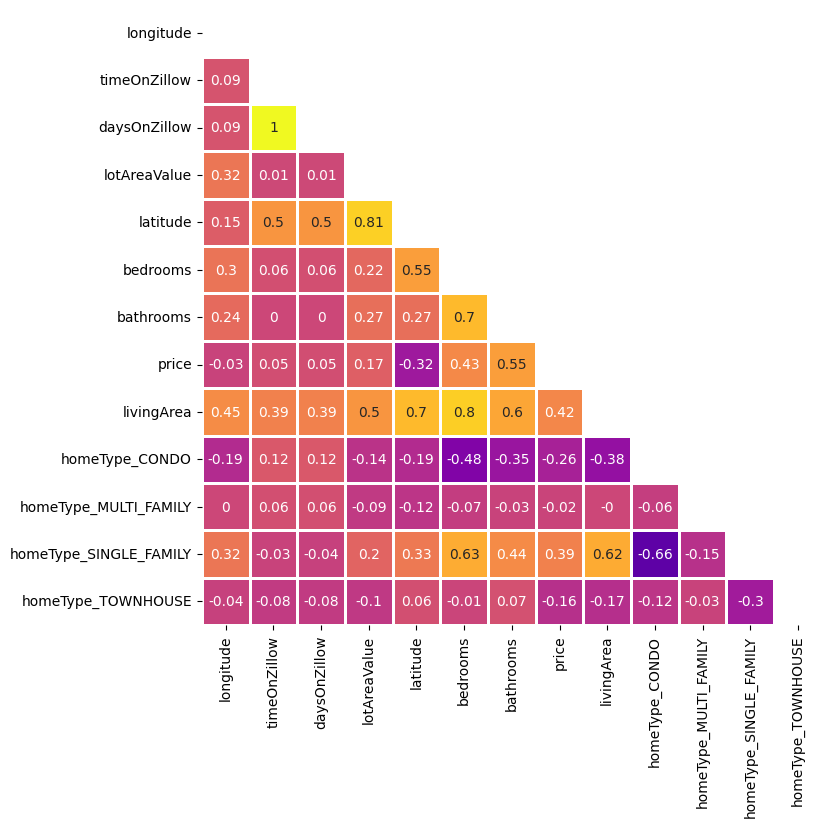

In [603]:
# this function is adopted from https://www.kaggle.com/code/shtrausslearning/bayesian-regression-house-price-prediction/notebook

def corrMat(df,id=False):
    corr_mat = df.corr().round(2)
    f, ax = plt.subplots(figsize=(8,8))
    # mask = np.zeros_like(corr_mat,dtype=np.bool)
    mask = np.zeros_like(corr_mat, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr_mat,mask=mask,vmin=-1,vmax=1,center=0, 
                cmap='plasma',square=False,lw=2,annot=True,cbar=False);plt.show()  
    
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
corrMat(df)


## Filling in Missing Living Area Values

Square footage is one of the most influential factors in determining house prices. The dataset includes living area (square footage) as a feature, but a significant number of records have missing values for this variable.
Base on the Coorelation matrix there is corelation between 'lotAreaValue', 'bedrooms', 'bathrooms', 'price' and living area square footage. Here we try fills in missing 'livingArea' values in a dataset using a machine learning model called Random Forest Regressor. It trains the model using known 'livingArea' values and other related features, then uses the trained model to predict the missing 'livingArea' values based on those features.

In [604]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def fill_missing_living_area(df):
    known_area = df[df['livingArea'].notnull()]
    unknown_area = df[df['livingArea'].isnull()]
    
    features = ['lotAreaValue', 'bedrooms', 'bathrooms', 'price']
    target = 'livingArea'
    
    X_known = known_area[features]
    y_known = known_area[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X_known, y_known, test_size=0.2, random_state=42)
    
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    y_pred = rf_model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-squared (R2):", r2)
    
    X_unknown = unknown_area[features]
    predicted_areas = rf_model.predict(X_unknown)
    
    df.loc[df['livingArea'].isnull(), 'livingArea'] = predicted_areas
    df.loc[df['livingArea'] < 0, 'livingArea'] = 0
    
    return df

df = fill_missing_living_area(df)

Mean Absolute Error (MAE): 426.2350555732148
Mean Squared Error (MSE): 302047.0618147725
Root Mean Squared Error (RMSE): 549.5880837634423
R-squared (R2): 0.7427439433412726


/Users/hamidhooshmandi/anaconda3/envs/USD/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


bathrooms have a strong positive correlation with bedrooms (0.7), which is expected since more bedrooms often mean more bathrooms.
based on this we create a 'Total Rooms' Feature: Since bathrooms and bedrooms are highly correlated, we create a new feature that combines them, such as total_rooms = bathrooms + bedrooms. This could help the model by consolidating two highly correlated features into one.

## Add bedrooms+bathrooms

In [605]:
def combine_and_drop(df):
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    df = df.drop(['bedrooms', 'bathrooms'], axis=1)
    df.head()
    return df

df = combine_and_drop(df)

## remove nan

In [606]:
def print_categorical_value_counts(df):
    categorical_columns = df.select_dtypes(include=['object', 'bool']).columns

    print("Categorical columns:"+ str(categorical_columns))

    for column in categorical_columns:
        print(f"Value counts for {column}:")
        print(df[column].value_counts())
        print("\n")

    print(f"Number of rows: {df.shape[0]}")
    df.head()
    return df

df = print_categorical_value_counts(df)

Categorical columns:Index([], dtype='object')
Number of rows: 4363


In [607]:
print(df.columns[df.isna().any()].tolist())

nan_cols = df.columns[df.isna().any()].tolist()

# df = df[df['price'].notna()]
# df = df[df['bedrooms'].notna() & df['bathrooms'].notna()]
# df = df[df['livingArea'].notna()]

for col in nan_cols:
    print(f"{col}: {df[col].isna().sum()}")

# Count columns with NaN values
nan_cols_count = df.columns[df.isna().any()].shape[0]
print(f"Number of columns with NaN values: {nan_cols_count}")

# Remove columns with NaN values
# df = df.dropna(axis=1)
print(f"Number of columns with NaN values: {nan_cols_count}")

print(f"Number of rows: {df.shape[0]}")
# print((df['bedrooms'] == 0).sum())
# df = df[df['bedrooms'] != 0]


print(f"Number of rows: {df.shape[0]}")
df.head()



['longitude', 'timeOnZillow', 'lotAreaValue', 'latitude']
longitude: 4008
timeOnZillow: 6
lotAreaValue: 2867
latitude: 4008
Number of columns with NaN values: 4
Number of columns with NaN values: 4
Number of rows: 4363
Number of rows: 4363


,longitude,timeOnZillow,daysOnZillow,lotAreaValue,latitude,price,livingArea,homeType_CONDO,homeType_MULTI_FAMILY,homeType_SINGLE_FAMILY,homeType_TOWNHOUSE,total_rooms
0,NaN,6.205267e+10,718,NaN,NaN,430000,1344.409161,1.0,0.0,0.0,0.0,1.0
1,-79.419914,8.036947e+10,930,NaN,43.661144,1452000,750.000000,0.0,0.0,1.0,0.0,1.0
2,NaN,8.131987e+10,941,NaN,NaN,430000,1344.409161,1.0,0.0,0.0,0.0,1.0
3,NaN,8.563987e+10,991,NaN,NaN,1300000,1552.920822,0.0,0.0,1.0,0.0,4.0
4,NaN,6.205267e+10,718,NaN,NaN,430000,1344.409161,1.0,0.0,0.0,0.0,1.0


## Handle missing values

In [608]:
def handle_missing_values(df):
    df = df[df['price'].notna()]
    df = df.dropna(axis=1)
    return df

df = handle_missing_values(df)

# Training the Model
Implementing a Linear Regression model and split the data into training and testing sets

In [609]:
# Final columns before training
print(f"Number of rows: {df.shape[0]}")

df.head()
# df.to_csv('training_dataset_saved.csv', index=False)

Number of rows: 4363


,daysOnZillow,price,livingArea,homeType_CONDO,homeType_MULTI_FAMILY,homeType_SINGLE_FAMILY,homeType_TOWNHOUSE,total_rooms
0,718,430000,1344.409161,1.0,0.0,0.0,0.0,1.0
1,930,1452000,750.000000,0.0,0.0,1.0,0.0,1.0
2,941,430000,1344.409161,1.0,0.0,0.0,0.0,1.0
3,991,1300000,1552.920822,0.0,0.0,1.0,0.0,4.0
4,718,430000,1344.409161,1.0,0.0,0.0,0.0,1.0


## Linear Regression

In [610]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np

def train_linear_regression(df, target):
    X = df.drop(target, axis=1)
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    linear_model = LinearRegression()
    linear_model.fit(X_train_scaled, y_train)
    
    y_pred = linear_model.predict(X_test_scaled)
    return y_test, y_pred

y_test_lin, y_pred_lin = train_linear_regression(df, 'price')



### Evaluation 

In [611]:
from sklearn.metrics import r2_score

def calculate_metrics(y_test, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r_squared = r2_score(y_test, y_pred)
    print(f"Root Mean Squared Error (RMSE) on Test Set for {model_name}: {rmse}")
    print(f"R-squared (R2) on Test Set for {model_name}: {r_squared}")
    print("---------------------------------------------------------------------------\n")

calculate_metrics(y_test_lin, y_pred_lin, 'Linear Regression')

Root Mean Squared Error (RMSE) on Test Set for Linear Regression: 702610.2823844797
R-squared (R2) on Test Set for Linear Regression: 0.2818240713478565
---------------------------------------------------------------------------



## Random Forest

In [612]:
from sklearn.ensemble import RandomForestRegressor

def train_random_forest(df, target):
    X = df.drop(target, axis=1)
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
    random_forest_model.fit(X_train_scaled, y_train)
    
    y_pred = random_forest_model.predict(X_test_scaled)
    return y_test, y_pred
y_test_rf, y_pred_rf = train_random_forest(df, 'price')



### Evaluation

In [613]:
calculate_metrics(y_test_rf, y_pred_rf, "Random Forest")


Root Mean Squared Error (RMSE) on Test Set for Random Forest: 104669.94412882194
R-squared (R2) on Test Set for Random Forest: 0.984061559448043
---------------------------------------------------------------------------



## Update coordinates and rerun
We cannot use addresses directly in the model, and the original dataset had only a few records with both latitude and longitude set. However, addresses are crucial for home price prediction. To incorporate addresses into the model, we used a Python script (get-data/geoapify.py) to call the Geoapify API and fetch coordinates (latitude and longitude) for the addresses. These coordinates were then saved in a CSV file (zillow_homes_sold_toronto_coordinates_added.csv), and the dataset was updated with the retrieved coordinates. The models will be rerun using this new dataset.

In [614]:
df = load_dataset("zillow_homes_sold_toronto_cordinations_added.csv")
df = drop_columns(df)
df = encode_homeType(df)
df = fill_missing_living_area(df)
df = remove_duplicates(df)
df = combine_and_drop(df)
df = handle_missing_values(df)
df.head()

Number of rows: 5220
columns_with_many_missing: Index([], dtype='object')
Columns dropped: ['currency', 'lotAreaUnit', 'isPreforeclosureAuction', 'zpid', 'priceForHDP', 'country', 'dateSold', 'isFeatured', 'isPremierBuilder', 'listing_sub_type', 'isShowcaseListing', 'shouldHighlight', 'isNonOwnerOccupied', 'streetAddress', 'homeStatusForHDP', 'homeStatus', 'taxAssessedValue', 'isUnmappable', 'zipcode', 'rentZestimate', 'isZillowOwned', 'city', 'state', 'zestimate']

Remaining columns: ['longitude', 'timeOnZillow', 'daysOnZillow', 'lotAreaValue', 'latitude', 'bedrooms', 'homeType', 'bathrooms', 'price', 'livingArea']
Number of rows: 5220
Mean Absolute Error (MAE): 409.7401142629799
Mean Squared Error (MSE): 270724.04157899175
Root Mean Squared Error (RMSE): 520.3114851499934
R-squared (R2): 0.7642229009796095


Duplicates before: 857
Duplicates after: 0
Number of rows: 4363


/Users/hamidhooshmandi/anaconda3/envs/USD/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,longitude,daysOnZillow,latitude,price,livingArea,homeType_CONDO,homeType_MULTI_FAMILY,homeType_SINGLE_FAMILY,homeType_TOWNHOUSE,total_rooms
0,-79.400083,718,43.636951,430000,1345.800574,1.0,0.0,0.0,0.0,1.0
1,-79.419914,930,43.661144,1452000,750.000000,0.0,0.0,1.0,0.0,1.0
2,-79.400083,941,43.636951,430000,1345.800574,1.0,0.0,0.0,0.0,1.0
3,-80.344809,991,43.355007,1300000,1388.423412,0.0,0.0,1.0,0.0,4.0
4,-79.400083,718,43.636951,430000,1345.800574,1.0,0.0,0.0,0.0,1.0


In [615]:
y_test_lin, y_pred_lin = train_linear_regression(df, 'price')
calculate_metrics(y_test_lin, y_pred_lin, "Linear Regression")

y_test_rf, y_pred_rf = train_random_forest(df, 'price')
calculate_metrics(y_test_rf, y_pred_rf, "Random Forest")


Root Mean Squared Error (RMSE) on Test Set for Linear Regression: 662352.6857885264
R-squared (R2) on Test Set for Linear Regression: 0.36176525141651195
---------------------------------------------------------------------------

Root Mean Squared Error (RMSE) on Test Set for Random Forest: 79947.17808153699
R-squared (R2) on Test Set for Random Forest: 0.9907016022416393
---------------------------------------------------------------------------



# RMSE Analysis
Average Price Context: The average price in the dataset is approximately $1,402,629. An RMSE of 79,947 represents about 5.7% of the average price, indicating a relatively small error relative to the average home value.

Compared to Standard Deviation: The standard deviation of the prices is $861,432.95, suggesting significant variability in house prices. An RMSE much smaller than the standard deviation indicates that the model predictions are reasonably accurate within the existing price variability.

Relative Error Scale: Considering the price range in the dataset, from a minimum of $1,600 to a maximum of $5,200,000, an RMSE of 74,350.92 demonstrates a moderate level of precision, especially effective for middle and high-end properties.

# Conclusion 
The Random Forest model significantly outperformed the Linear Regression model, indicating its better suitability for this application. 
The results validate the effectiveness of the Random Forest model in predicting housing prices with high accuracy. Future efforts might focus on integrating more dynamic features and improving data collection to refine predictions further. This is likely due to:

Non-linearity: Random Forest can capture complex, non-linear relationships between features that affect housing prices

Robust to Outliers: This model is less sensitive to extreme values, which are common in real estate markets, like the occasional luxury home sales that do not fit typical pricing patterns.

Feature Interactions: Random Forest automatically considers how combinations of features impact house prices. For example, the model can intuitively assess how the interaction between property size and its location (represented by latitude and longitude) affects its value, unlike Linear Regression, which requires explicitly crafted interaction terms to capture such complex relationships.

Prevention of Overfitting: Random Forest uses techniques like bootstrapping and feature randomness to build diverse trees that generalize better to new data, reducing the risk of overfitting seen in complex Linear Regression models.

Handles Various Data Types: It effortlessly processes different data types and does not require extensive preprocessing for categorical variables, streamlining the modeling process.


# Model imporovements
Following potentially can be done to improve model's performance:

Feature Engineering: Develop new features that capture more nuances of the real estate market, such as proximity to amenities or property condition or walking score.

Data Enrichment: Integrate additional data sources, such as economic indicators or demographic statistics, to provide more context for predictions.

Advanced Modeling Techniques: Experiment with more complex models like Gradient Boosting Machines (GBM) or neural networks that might capture patterns better.

Parameter Tuning: Optimize hyperparameters of the Random Forest model through grid search or random search to enhance model accuracy.

Handling Outliers: Identify and manage outliers in the dataset that may skew the model predictions.